In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from lib.nb_08c import *

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
next(iter(data.train_dl))[0].shape

torch.Size([64, 3, 128, 128])

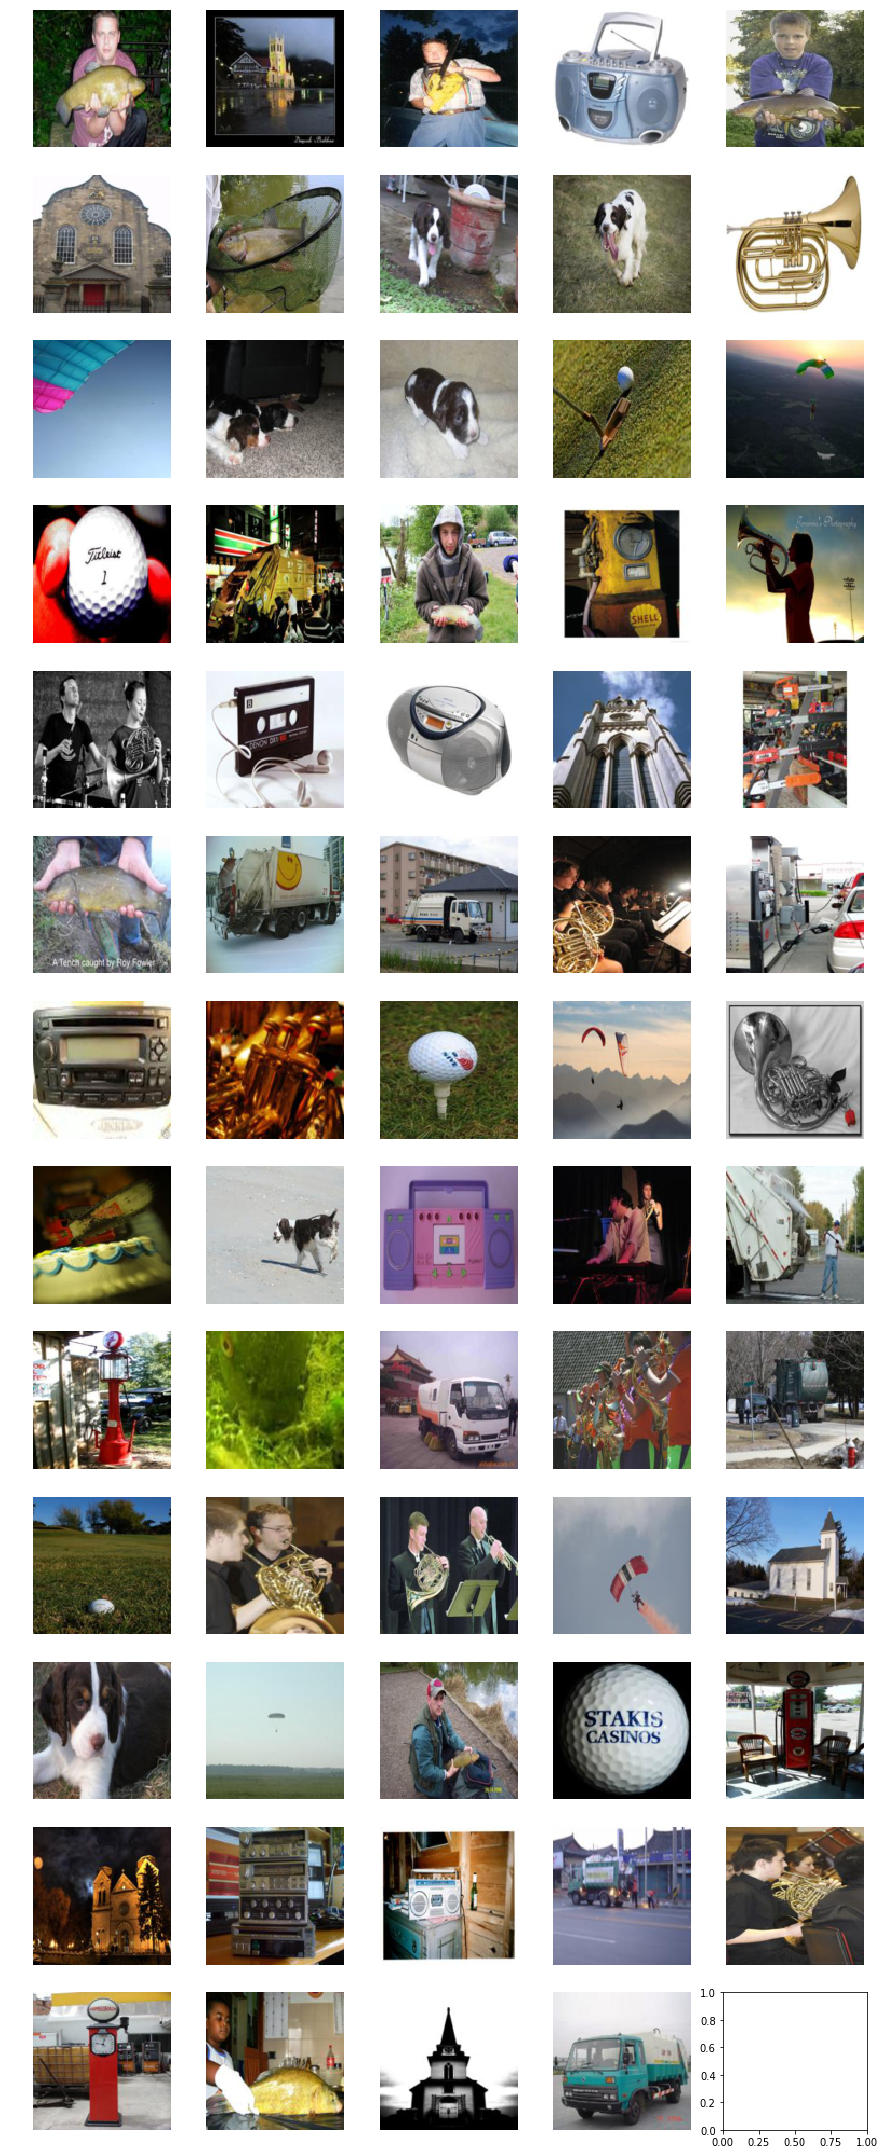

In [6]:
show_batch(next(iter(data.train_dl))[0], c=5)

### Mixup

Large deep neural networks are powerful, but exhibit undesirable behaviors such
as memorization and sensitivity to adversarial examples. In this work, we propose
[mixup](https://arxiv.org/pdf/1710.09412.pdf), a simple learning principle to alleviate these issues. In essence, mixup trains
a neural network on convex combinations of pairs of examples and their labels.
By doing so, mixup regularizes the neural network to favor simple linear behavior
in-between training examples.

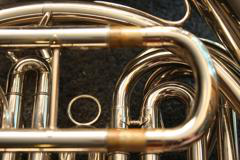

In [7]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

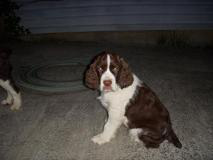

In [8]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

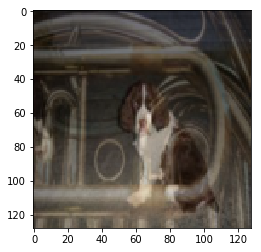

In [9]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

In [10]:
Γ = lambda x: x.lgamma().exp()

In [11]:
facts = [math.factorial(i) for i in range(7)]

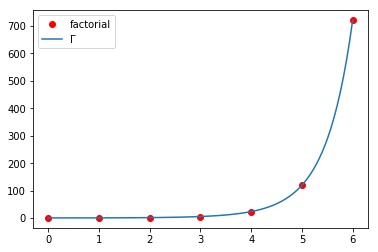

In [12]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);

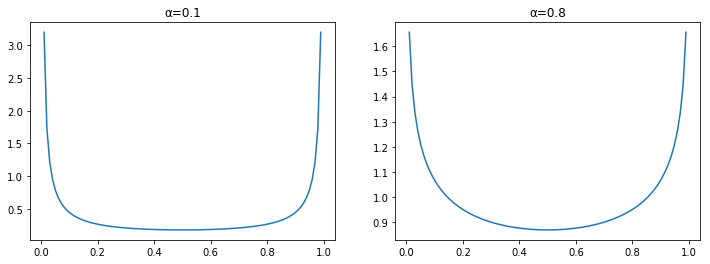

In [13]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

In [14]:
#export
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)    

In [15]:
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

In [30]:
class MixUp(Callback):
    
    _order = 90 #Runs after normalization and cuda
    
    def __init__(self, α=0.4):
        self.distrib = Beta(tensor([α]), tensor([α]))
        
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [39]:
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

In [40]:
nfs = [32,64,128,256,512]

In [41]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.to(get_device()), std=_s.to(get_device()))

In [42]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(CudaCallback, get_device()), 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

In [43]:
data.c_in, data.c_out

(3, 10)

In [44]:
def get_cnn_layers(data, nfs, layer, color=True, **kwargs):
    nfs = [3 if color else 1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c_out)]

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [45]:
model =  get_cnn_model(data, nfs, conv_rbn, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model, uniform=True)

In [46]:
lr = 1e-2

sched_lr  = combine_scheds([0.3,0.7], cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.8, 0.7, 0.8))
cbsched = [ParamScheduler('lr', sched_lr) , ParamScheduler('mom', sched_mom)]


learn = Learner(model, data, loss_func=F.cross_entropy, cb_funcs=cbfs, opt_func=adam_opt())

In [47]:
learn.fit(1, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.964385,0.372809,1.361925,0.552000,04:38


In [ ]:
l